In [7]:
import numpy as np
import pandas as pd
import scanpy as sc
import matplotlib.pyplot as plt
from matplotlib.ticker import NullFormatter
import scipy.stats as st
from scipy import stats
from sklearn.neighbors import NearestCentroid
import numpy as np
import seaborn as sns

np.random.seed(41)

sc.settings.verbosity = 3             # verbosity: errors (0), warnings (1), info (2), hints (3)
#sc.logging.print_versions()
sc.set_figure_params(figsize=None)

RANDOM_SEED = 110011

In [2]:
# Read pre-processed data
save_file = '../data/h5ab_folder/gse159812_raw_covid_normalized_preprocessed.h5ad'
adata = sc.read_h5ad(save_file)
adata

AnnData object with n_obs × n_vars = 114701 × 2680
    obs: 'sample', 'batch', 'n_genes_by_counts', 'total_counts', 'total_counts_mt', 'pct_counts_mt', 'total_counts_ribo', 'pct_counts_ribo', 'total_counts_hb', 'pct_counts_hb', 'percent_mt2', 'n_counts', 'n_genes', 'S_score', 'G2M_score', 'phase', 'doublet_scores', 'predicted_doublets', 'doublet_info'
    var: 'gene_id', 'mt', 'ribo', 'hb', 'n_cells_by_counts', 'mean_counts', 'pct_dropout_by_counts', 'total_counts', 'n_cells', 'highly_variable', 'means', 'dispersions', 'dispersions_norm', 'mean', 'std'
    uns: 'doublet_info_colors', 'hvg', 'log1p', 'neighbors', 'pca', 'sample_colors', 'tsne', 'umap'
    obsm: 'X_pca', 'X_tsne', 'X_umap'
    varm: 'PCs'
    obsp: 'connectivities', 'distances'

In [3]:
# Delete 'X_umap' for this experiment.
del adata.obsm['X_umap']
del adata.uns['neighbors']
del adata.uns['pca']
del adata.obsm['X_pca']
del adata.uns['umap']
del adata.varm['PCs']
del adata.obsp

In [4]:
from sklearn.model_selection import train_test_split
list_samples = list(adata.obs['sample'].unique())
y_train, y_test = train_test_split(list_samples, test_size=0.20, random_state=110011)

print("Samples for getting centroids of existing samples (covid and non-covid):", y_train) # 4 samples
print("Samples for testing:", y_test) # 2 samples

Samples for getting centroids of existing samples (covid and non-covid): ['Control_9', 'COVID-19_3', 'Influenza_2', 'COVID-19_15', 'COVID-19_10', 'Control_4', 'Control_6', 'Control_7', 'Control_5', 'COVID-19_1', 'COVID-19_5', 'Control_2', 'COVID-19_9', 'Control_11', 'COVID-19_7', 'Control_8', 'COVID-19_14', 'COVID-19_11', 'COVID-19_8', 'COVID-19_13', 'COVID-19_6', 'Control_10', 'Control_3', 'Control_12']
Samples for testing: ['COVID-19_2', 'Control_13', 'Control_1', 'COVID-19_4', 'COVID-19_12', 'Influenza_1']


In [5]:
### Make adata for train/existing data.
# Make a column that contains bool values based on whether the sample_name holds one of the samples in the y_train..
adata.obs['contain_y_train'] = adata.obs['sample'].isin(y_train)

# Copy adata
adata_train = adata.copy()
# Remove cells that don't belong to y_train
adata_train = adata_train[adata_train.obs['contain_y_train'] == True,:]


### Make adata for train/existing data.
# Make a column that contains bool values based on whether the sample_name holds one of the samples in the y_train..
adata.obs['contain_y_test'] = adata.obs['sample'].isin(y_test)

# Copy adata
adata_test = adata.copy()
# Remove cells that don't belong to y_train
adata_test = adata_test[adata_test.obs['contain_y_test'] == True,:]

Apply UMAP to the train adata. Make sure both adata (train/refrence and test) have the same genes.

In [6]:
sc.pp.neighbors(adata_train, n_pcs = 30, n_neighbors = 20) 
sc.tl.pca(adata_train)
sc.tl.umap(adata_train)
#sc.pl.umap(adata_train, color='sample')
#sc.tl.ingest(adata_test, adata_train, obs='sample', embedding_method='umap')
sc.tl.ingest(adata_test, adata_train, embedding_method='umap')

computing neighbors
         Falling back to preprocessing with `sc.pp.pca` and default params.
computing PCA
    with n_comps=50
    finished (0:00:09)
    finished: added to `.uns['neighbors']`
    `.obsp['distances']`, distances for each pair of neighbors
    `.obsp['connectivities']`, weighted adjacency matrix (0:00:39)
computing PCA
    on highly variable genes
    with n_comps=50
    finished (0:00:07)
computing UMAP
    finished: added
    'X_umap', UMAP coordinates (adata.obsm) (0:00:45)
running ingest
    finished (0:00:23)


Concatenate both `adata_train` and `adata_test` for further analysis.

In [7]:
adata_concat = adata_train.concatenate(adata_test, batch_categories=['ref', 'new'])
adata = adata_concat.copy()

/opt/homebrew/Caskroom/miniforge/base/envs/scanpy_tutorial/lib/python3.9/site-packages/anndata/_core/anndata.py:1785: FutureWarning: X.dtype being converted to np.float32 from float64. In the next version of anndata (0.9) conversion will not be automatic. Pass dtype explicitly to avoid this warning. Pass `AnnData(X, dtype=X.dtype, ...)` to get the future behavour.
  [AnnData(sparse.csr_matrix(a.shape), obs=a.obs) for a in all_adatas],


/opt/homebrew/Caskroom/miniforge/base/envs/scanpy_tutorial/lib/python3.9/site-packages/scanpy/plotting/_tools/scatterplots.py:392: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  cax = scatter(


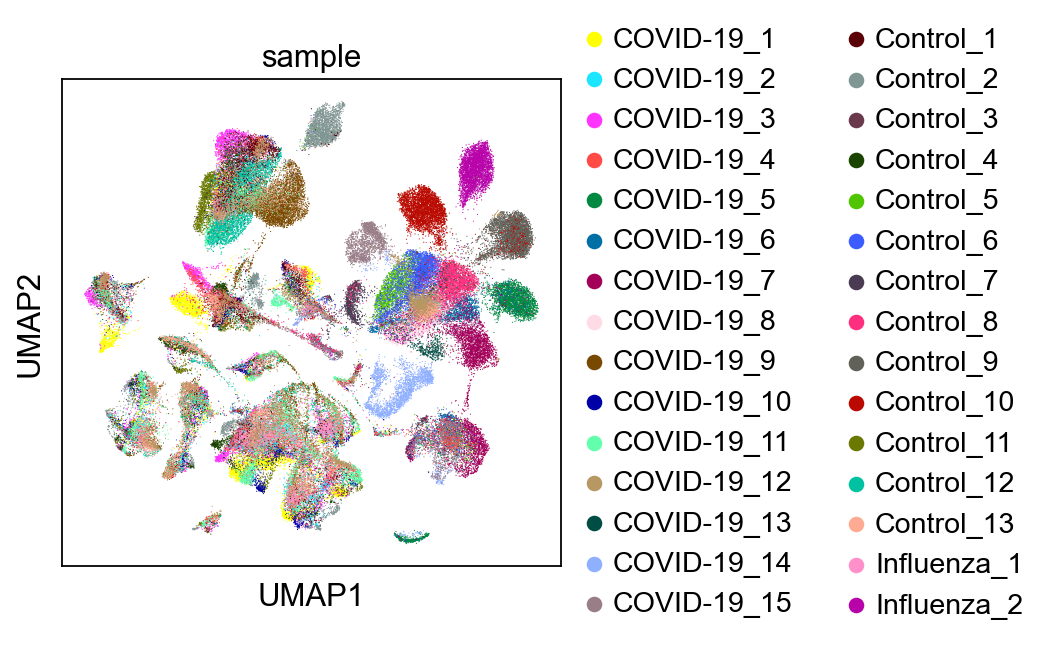

In [8]:
sc.pl.umap(adata, color='sample')

### Read ingested and concatenated adata if we have done it before

In [2]:
# Read pre-processed data
save_file = '../data/h5ab_folder/ingest_gse159812_raw_covid_normalized_preprocessed_PCA.h5ad'
adata = sc.read_h5ad(save_file)
adata

AnnData object with n_obs × n_vars = 114701 × 2680
    obs: 'sample', 'batch', 'n_genes_by_counts', 'total_counts', 'total_counts_mt', 'pct_counts_mt', 'total_counts_ribo', 'pct_counts_ribo', 'total_counts_hb', 'pct_counts_hb', 'percent_mt2', 'n_counts', 'n_genes', 'S_score', 'G2M_score', 'phase', 'doublet_scores', 'predicted_doublets', 'doublet_info'
    var: 'gene_id', 'mt', 'ribo', 'hb', 'n_cells_by_counts', 'mean_counts', 'pct_dropout_by_counts', 'total_counts', 'n_cells', 'highly_variable', 'means', 'dispersions', 'dispersions_norm', 'mean', 'std'
    obsm: 'X_pca', 'X_tsne'

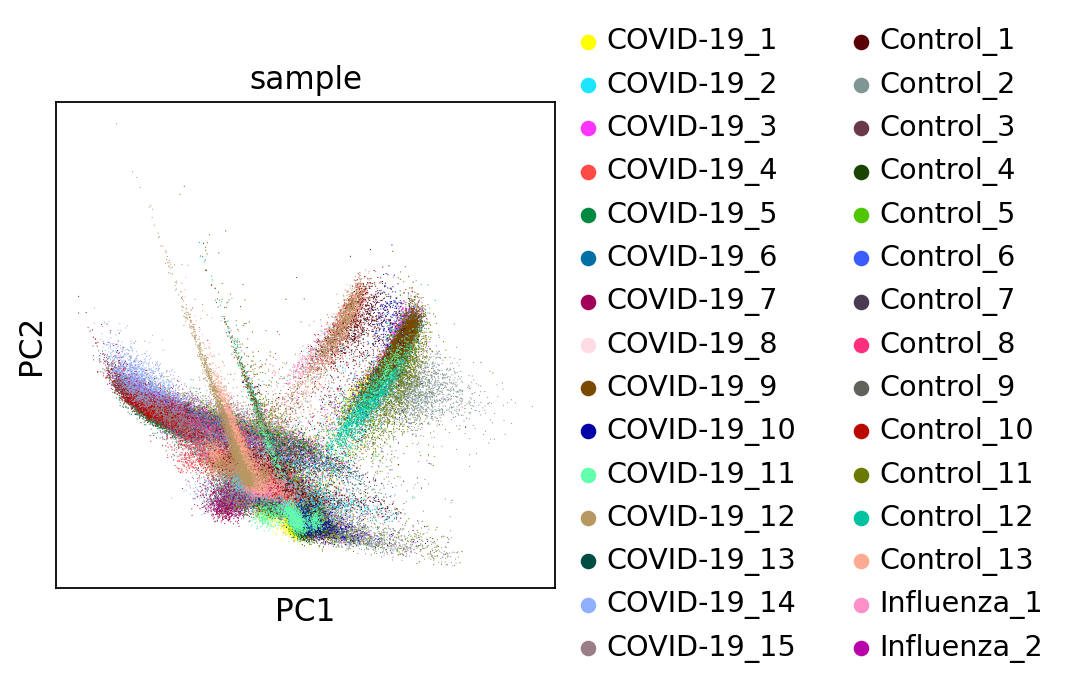

In [3]:
sc.pl.pca(adata, color='sample')

### Get centroids of each samples

In [4]:
basis_values = adata.obsm['X_pca'][:, :2]
sample_vector = adata.obs['sample'].values
x_basis_value = []
y_basis_value = []

for b_v in basis_values:
    x_basis_value.append(b_v[0])
    y_basis_value.append(b_v[1])

df = pd.DataFrame(list(zip(basis_values, sample_vector, x_basis_value, y_basis_value)),
               columns =['basis_value', 'sample', 'x_basis_value', 'y_basis_value'])
df.head()

X = np.stack(df.basis_value.values.tolist()[:])
y = df['sample'].tolist()
clf = NearestCentroid()
clf.fit(X, y)

#print("Centroids:", clf.centroids_)


NearestCentroid()

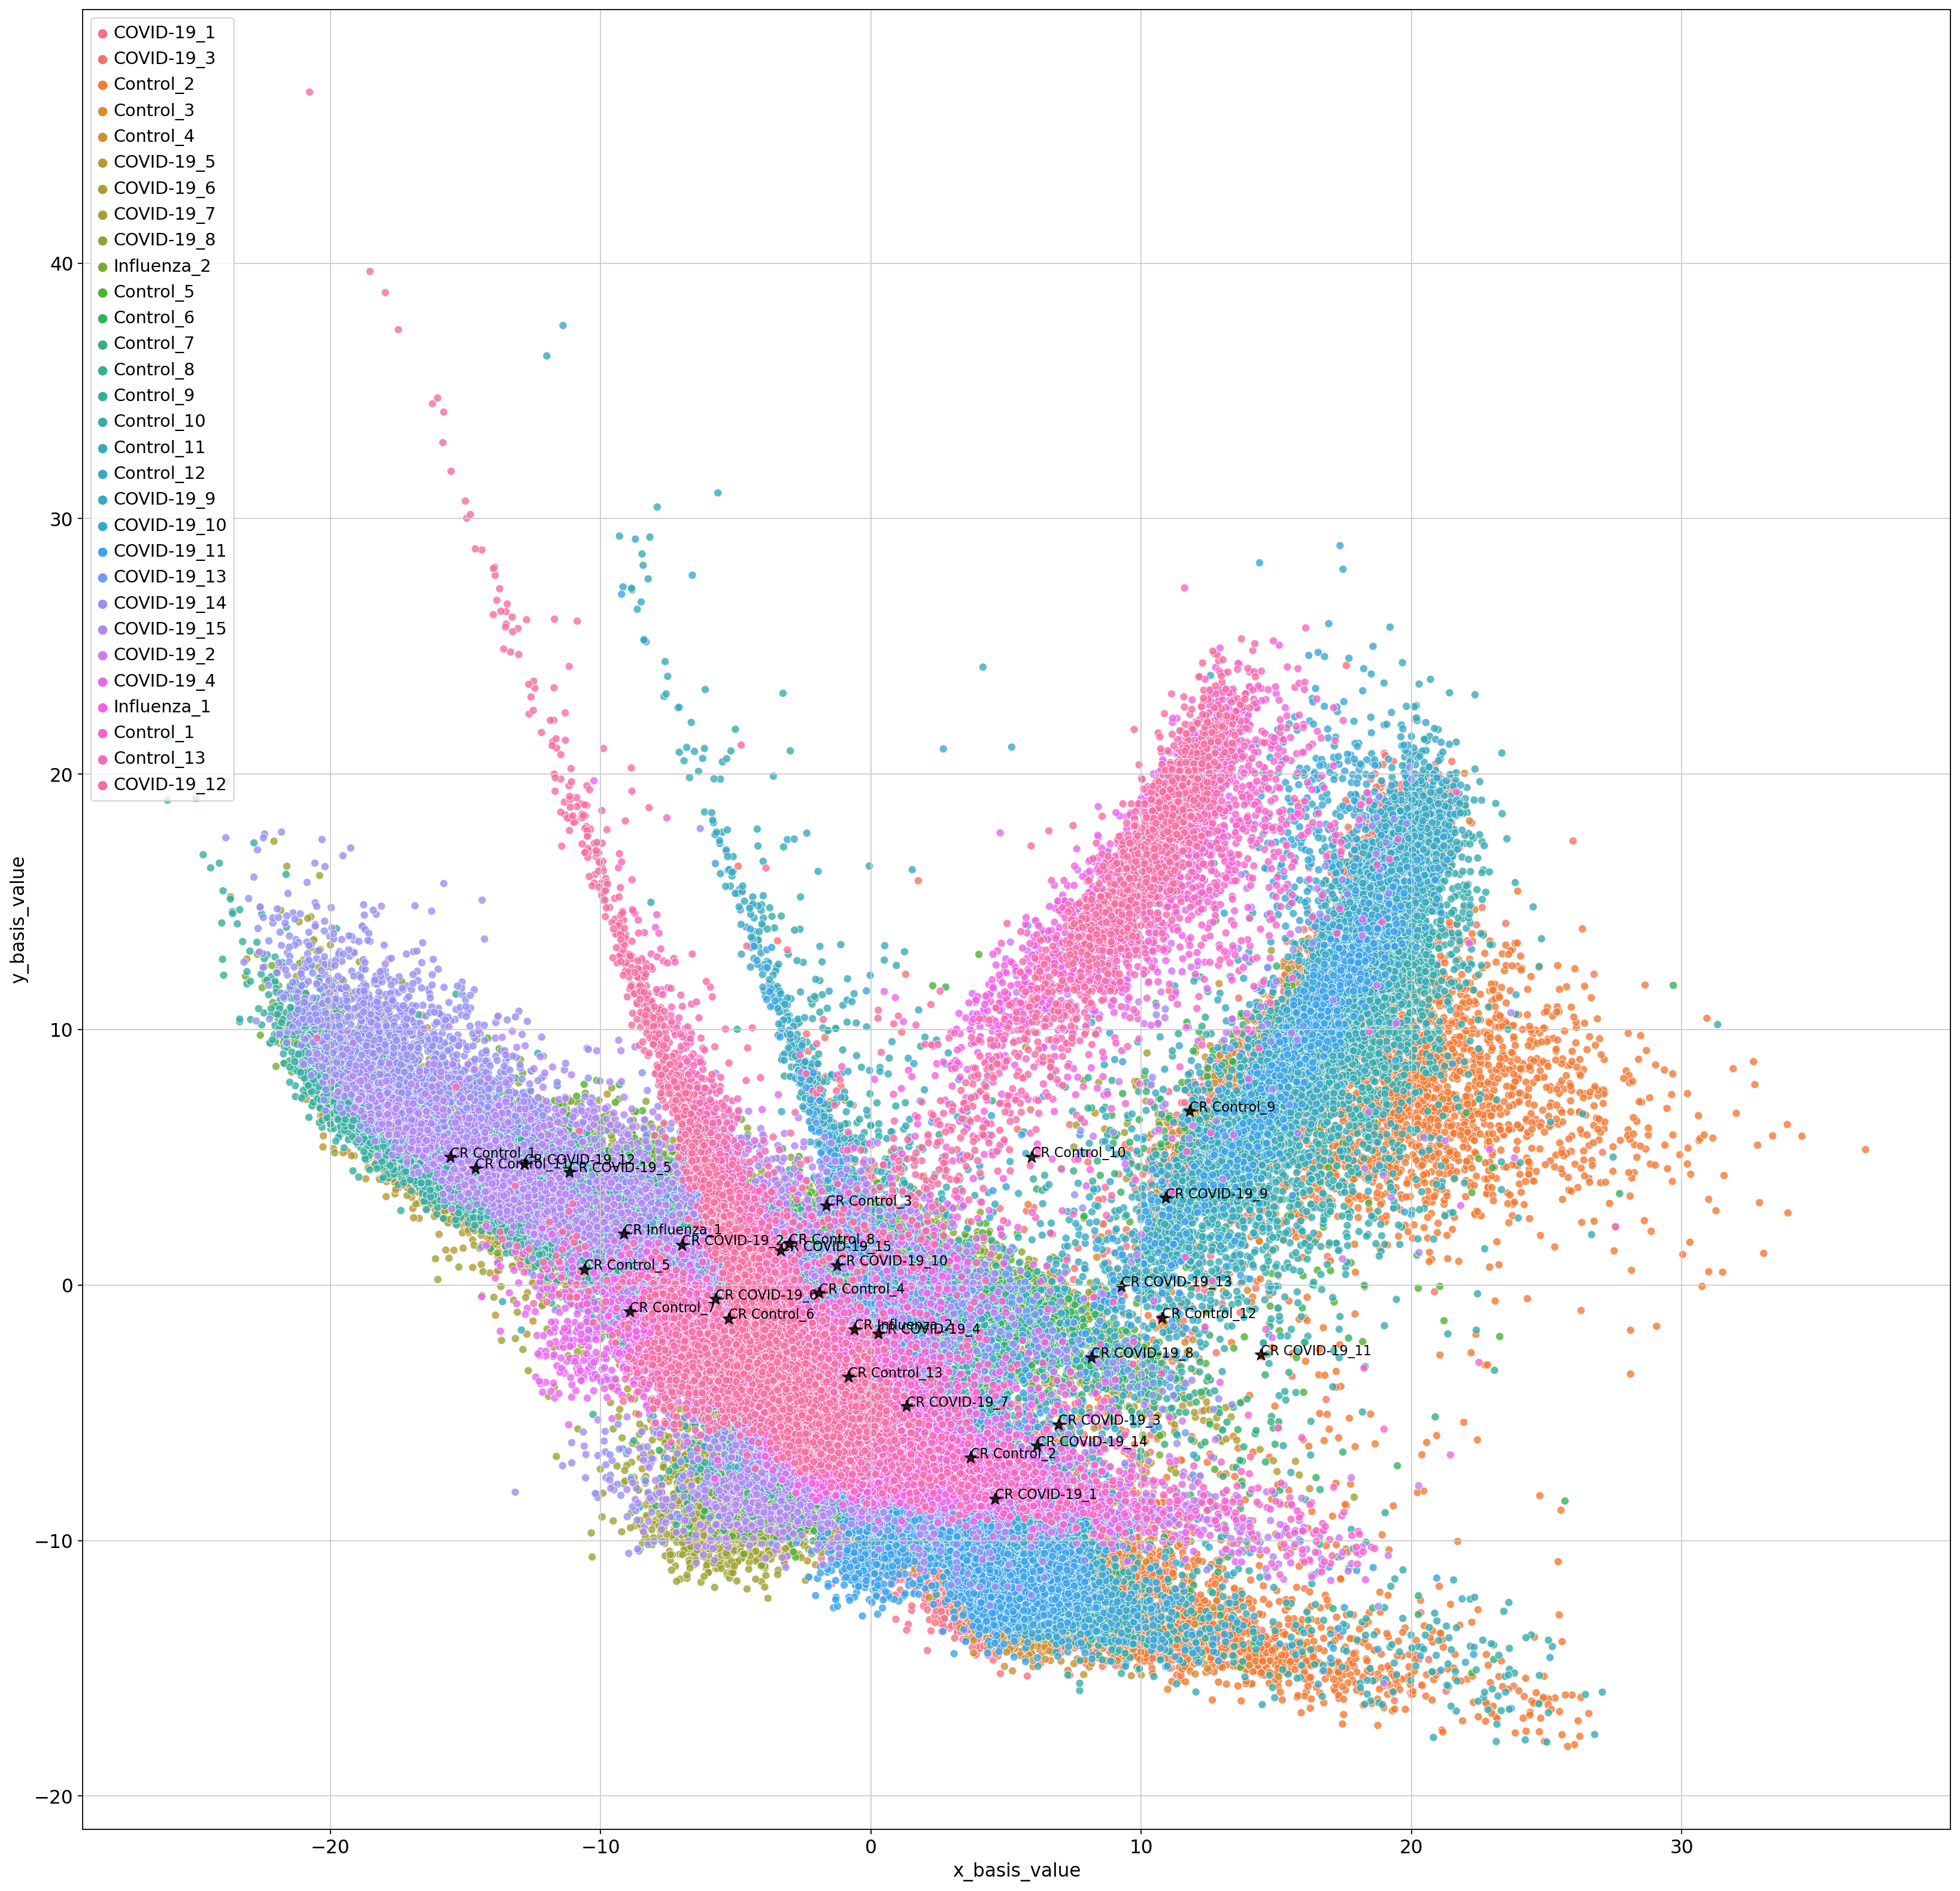

In [6]:
list_samples = df['sample'].unique()
sns.scatterplot(x='x_basis_value', y='y_basis_value', data=df, hue='sample', alpha=0.8)
#sns.lmplot(x='x_basis_value', y='y_basis_value', data=df, hue='sample', fit_reg=False)

centroid_id = 0
for centroid in clf.centroids_:
    plt.scatter(centroid[0], centroid[1], s=80, alpha=0.8, marker="*", color='black')
    plt.text(centroid[0], centroid[1], f'CR {list_samples[centroid_id]}', color='black', fontsize=10)
    centroid_id+= 1

# Show the plot
sc.set_figure_params(figsize=(25, 25))
plt.legend(loc="upper left")
plt.show()

### Split samples into train and test

In [8]:
from sklearn.model_selection import train_test_split

y_train, y_test = train_test_split(list_samples, test_size=0.20, random_state=RANDOM_SEED)

print("Samples for getting centroids of existing samples (covid and non-covid):", y_train)
print("Samples for testing:", y_test)
print()
print(f"Size of the train samples: {len(y_train)}, the test sample: {len(y_test)}")

Samples for getting centroids of existing samples (covid and non-covid): ['COVID-19_9' 'Control_2' 'Control_8' 'COVID-19_12' 'COVID-19_2'
 'COVID-19_8' 'Control_10' 'Control_11' 'Control_9' 'COVID-19_1'
 'Influenza_2' 'COVID-19_6' 'COVID-19_15' 'COVID-19_11' 'Control_6'
 'Control_12' 'Control_13' 'COVID-19_4' 'Control_7' 'Control_1'
 'Control_5' 'COVID-19_10' 'COVID-19_7' 'COVID-19_13']
Samples for testing: ['COVID-19_3' 'COVID-19_14' 'COVID-19_5' 'Control_3' 'Influenza_1'
 'Control_4']

Size of the train samples: 24, the test sample: 6


## Sample Classification: Scenario 3.1

### Input data
UMAP representation (UMAP 1 - UMAP 2)

### Method
Run kmeans clusterning and get clusters. Encode exsting samples (covid and non-covid) clusters into further by Euclidian distance between those centroids. Apply some linear classifier to train. Count the label prediction of a new sample because it’s encoded into distance expression, so that it derives how many cells are close with each exciting cluster/samples (covid or non-covid). 

This implementation is the same as this paper: 
A study on using data clustering for feature extraction to improve the quality of classification


In [12]:
pca1 = adata.obsm['X_pca'][:, 0]
pca2 = adata.obsm['X_pca'][:, 1]
sample_vector = adata.obs['sample'].values

df = pd.DataFrame(list(zip(pca1, pca2, sample_vector)),
               columns =['pca1', 'pca2', 'sample'])
df

pca1       pca2       sample
0        3.753321 -13.429734   COVID-19_1
1        3.979202 -12.973167   COVID-19_1
2        1.532645  -9.951640   COVID-19_1
3        0.575898  -8.628656   COVID-19_1
4        3.398257 -12.020443   COVID-19_1
...           ...        ...          ...
114696   8.101749  13.275001  COVID-19_12
114697 -11.124621  18.713410  COVID-19_12
114698  -1.386368  -5.933936  COVID-19_12
114699  -6.088396  11.881803  COVID-19_12
114700  -3.402052  -4.531804  COVID-19_12

[114701 rows x 3 columns]

In [13]:
list_covid_non_covid = []
for index, row in df.iterrows():
     if 'covid' in row['sample'] or 'COVID' in row['sample']:
          list_covid_non_covid.append('covid')
     else:
          list_covid_non_covid.append('non_covid')

df['covid_non_covid'] = list_covid_non_covid
df

pca1       pca2       sample covid_non_covid
0        3.753321 -13.429734   COVID-19_1           covid
1        3.979202 -12.973167   COVID-19_1           covid
2        1.532645  -9.951640   COVID-19_1           covid
3        0.575898  -8.628656   COVID-19_1           covid
4        3.398257 -12.020443   COVID-19_1           covid
...           ...        ...          ...             ...
114696   8.101749  13.275001  COVID-19_12           covid
114697 -11.124621  18.713410  COVID-19_12           covid
114698  -1.386368  -5.933936  COVID-19_12           covid
114699  -6.088396  11.881803  COVID-19_12           covid
114700  -3.402052  -4.531804  COVID-19_12           covid

[114701 rows x 4 columns]

#### Split the dataset into train: df_exist and test: df_new

In [14]:
list_samples = df['sample'].unique()

#y_train, y_test = train_test_split(list_samples, test_size=0.20, random_state=111)

print("Samples for getting centroids of existing samples (covid and non-covid):", y_train) # 4 samples
print("Samples for testing:", y_test) # 2 samples

Samples for getting centroids of existing samples (covid and non-covid): ['COVID-19_9' 'Control_2' 'Control_8' 'COVID-19_12' 'COVID-19_2'
 'COVID-19_8' 'Control_10' 'Control_11' 'Control_9' 'COVID-19_1'
 'Influenza_2' 'COVID-19_6' 'COVID-19_15' 'COVID-19_11' 'Control_6'
 'Control_12' 'Control_13' 'COVID-19_4' 'Control_7' 'Control_1'
 'Control_5' 'COVID-19_10' 'COVID-19_7' 'COVID-19_13']
Samples for testing: ['COVID-19_3' 'COVID-19_14' 'COVID-19_5' 'Control_3' 'Influenza_1'
 'Control_4']


In [15]:
# Make a dataframe for training
y_train = list(y_train)
df_exist = df.query("sample == @y_train")
df_exist

pca1       pca2       sample covid_non_covid
0        3.753321 -13.429734   COVID-19_1           covid
1        3.979202 -12.973167   COVID-19_1           covid
2        1.532645  -9.951640   COVID-19_1           covid
3        0.575898  -8.628656   COVID-19_1           covid
4        3.398257 -12.020443   COVID-19_1           covid
...           ...        ...          ...             ...
114696   8.101749  13.275001  COVID-19_12           covid
114697 -11.124621  18.713410  COVID-19_12           covid
114698  -1.386368  -5.933936  COVID-19_12           covid
114699  -6.088396  11.881803  COVID-19_12           covid
114700  -3.402052  -4.531804  COVID-19_12           covid

[94151 rows x 4 columns]

In [16]:
# Make a dataframe for testing
y_test = list(y_test)
df_new = df.query("sample == @y_test")
df_new

pca1       pca2       sample covid_non_covid
6685    11.348796 -13.072659   COVID-19_3           covid
6686     4.353441 -10.521884   COVID-19_3           covid
6687     5.791921  -7.691867   COVID-19_3           covid
6688     6.145808 -12.797969   COVID-19_3           covid
6689     5.688179  -9.089688   COVID-19_3           covid
...           ...        ...          ...             ...
103625   1.036191  -7.501033  Influenza_1       non_covid
103626  -2.301092  -3.198891  Influenza_1       non_covid
103627   0.042016  -7.241218  Influenza_1       non_covid
103628  -3.346469  -5.900397  Influenza_1       non_covid
103629   0.509905  -7.209088  Influenza_1       non_covid

[20550 rows x 4 columns]

### Run Kmeans clusterning to get clusters' centroids as a cluster representation.

Also, check the elbow to determine the number of clusters (the parameter `k`).

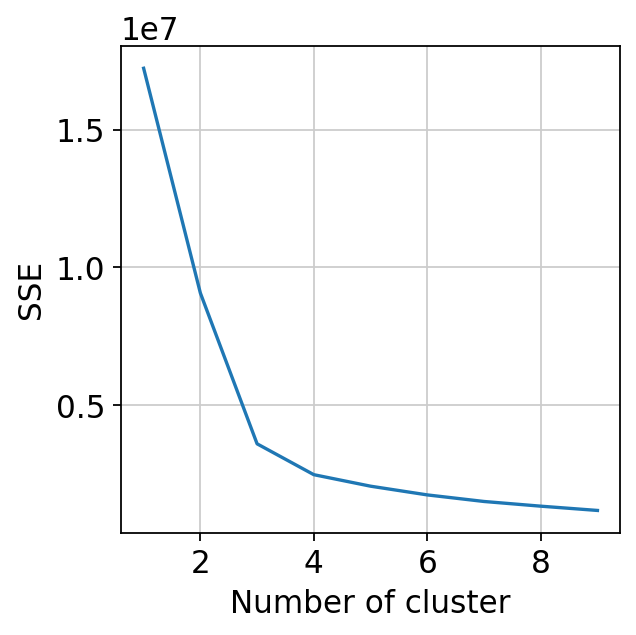

In [17]:
from sklearn.cluster import KMeans
sc.set_figure_params(figsize=None)

data = (df_exist[['pca1', 'pca2']])
inertias = []

kmeans = KMeans(n_clusters=2)
kmeans.fit(data)
centroids = kmeans.cluster_centers_

sse = {}
for k in range(1, 10):
    kmeans = KMeans(n_clusters=k).fit(data)
    sse[k] = kmeans.inertia_ # Inertia: Sum of distances of samples to their closest cluster center
plt.figure()
plt.plot(list(sse.keys()), list(sse.values()))
plt.xlabel("Number of cluster")
plt.ylabel("SSE")
plt.show()

According to the above plot, we shall use `k=3` this time.<br>
<br>

Next, train a kmeans again with `k=4`, and get distances between each centroid and each sample, and then append them to the dataframe.

/tmp/ipykernel_2683198/1801552858.py:19: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_exist[f'dist_centorid_{i}'] = temp_dist_sample_centroids
/tmp/ipykernel_2683198/1801552858.py:19: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_exist[f'dist_centorid_{i}'] = temp_dist_sample_centroids
/tmp/ipykernel_2683198/1801552858.py:19: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the docum

<AxesSubplot:xlabel='dist_centorid_0', ylabel='dist_centorid_2'>

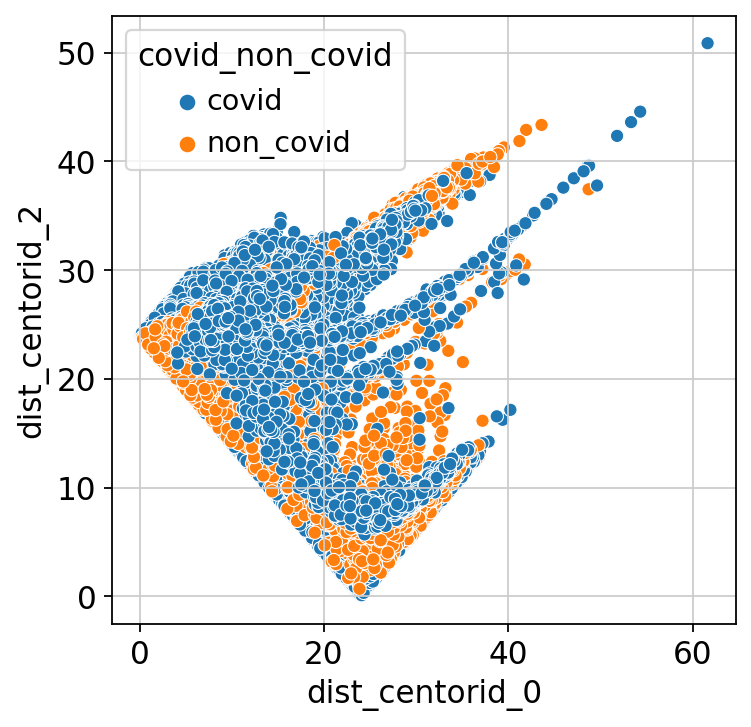

In [18]:
k = 4
kmeans = KMeans(n_clusters=k)
kmeans.fit(data)
centroids = kmeans.cluster_centers_

### Compute a distance
for i in range(len(centroids)):
    cur_centroid = np.array(centroids[i])
    # Traverse each row to calculate the distance between the centroid 
    # and the coordinates of each sample.
    temp_dist_sample_centroids = []
    for index, row in df_exist.iterrows():
        coord = np.array([row['pca1'], row['pca2']])
        dist = np.linalg.norm(cur_centroid - coord)

        temp_dist_sample_centroids.append(dist)
    
    # Add dinstances between each row and selected centroid to existing df.
    df_exist[f'dist_centorid_{i}'] = temp_dist_sample_centroids

# Plot the result of the transformation in distance between each sample and centroids
sc.set_figure_params(figsize=(5, 5))
sns.scatterplot(data=df_exist, x="dist_centorid_0", y="dist_centorid_2", hue='covid_non_covid')

Also, print the augmented dataframe.

In [19]:
df_exist

pca1       pca2       sample covid_non_covid  dist_centorid_0  \
0        3.753321 -13.429734   COVID-19_1           covid         4.285533   
1        3.979202 -12.973167   COVID-19_1           covid         3.785653   
2        1.532645  -9.951640   COVID-19_1           covid         3.455932   
3        0.575898  -8.628656   COVID-19_1           covid         4.405048   
4        3.398257 -12.020443   COVID-19_1           covid         3.113827   
...           ...        ...          ...             ...              ...   
114696   8.101749  13.275001  COVID-19_12           covid        22.805284   
114697 -11.124621  18.713410  COVID-19_12           covid        32.294177   
114698  -1.386368  -5.933936  COVID-19_12           covid         7.159646   
114699  -6.088396  11.881803  COVID-19_12           covid        23.882825   
114700  -3.402052  -4.531804  COVID-19_12           covid         9.602532   

        dist_centorid_1  dist_centorid_2  dist_centorid_3  
0             25.274102        28.191913        13.087392  
1             25.101923        27.682526        12.805539  
2             21.235023        26.300800         8.971486  
3             19.627059        25.787220         7.359644  
4             24.016386        27.103459        11.689685  
...                 ...              ...              ...  
114696        23.251339         8.301472        18.662667  
114697        13.993999        28.252605        22.390651  
114698        16.356926        25.049112         4.123477  
114699        10.230834        22.364630        14.307944  
114700        13.922126        25.590653         2.649829  

[94151 rows x 8 columns]

Train the augmented dataset in SVM

In [20]:
from sklearn.svm import SVC

# Prepare training data for building the model
X_train = df_exist.drop(['sample', 'covid_non_covid'], axis=1)
y_train = df_exist['covid_non_covid']

# Instantiate the model
cls = SVC()
# Train/Fit the model 
cls.fit(X_train, y_train)

SVC()

Print the dataframe for the test data/new samples

In [21]:
df_new

pca1       pca2       sample covid_non_covid
6685    11.348796 -13.072659   COVID-19_3           covid
6686     4.353441 -10.521884   COVID-19_3           covid
6687     5.791921  -7.691867   COVID-19_3           covid
6688     6.145808 -12.797969   COVID-19_3           covid
6689     5.688179  -9.089688   COVID-19_3           covid
...           ...        ...          ...             ...
103625   1.036191  -7.501033  Influenza_1       non_covid
103626  -2.301092  -3.198891  Influenza_1       non_covid
103627   0.042016  -7.241218  Influenza_1       non_covid
103628  -3.346469  -5.900397  Influenza_1       non_covid
103629   0.509905  -7.209088  Influenza_1       non_covid

[20550 rows x 4 columns]

In [22]:
# Get distance between a new sample and existing centroids
for i in range(len(centroids)):
    cur_centroid = np.array(centroids[i])
    # Traverse each row to calculate the distance between the centroid 
    # and the coordinates of each sample.
    temp_dist_sample_centroids = []
    for index, row in df_new.iterrows():
        coord = np.array([row['pca1'], row['pca2']])
        dist = np.linalg.norm(cur_centroid - coord)

        temp_dist_sample_centroids.append(dist)
    
    # Add dinstances between each row and selected centroid to existing df.
    df_new[f'dist_centorid_{i}'] = temp_dist_sample_centroids

# Run prediction
X_test = df_new.drop(['sample', 'covid_non_covid'], axis=1)
y_test = df_new['covid_non_covid']
y_pred = cls.predict(X_test)

df_new['y_pred'] = y_pred


/tmp/ipykernel_2683198/1084251464.py:14: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_new[f'dist_centorid_{i}'] = temp_dist_sample_centroids
/tmp/ipykernel_2683198/1084251464.py:14: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_new[f'dist_centorid_{i}'] = temp_dist_sample_centroids
/tmp/ipykernel_2683198/1084251464.py:14: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documenta

In [23]:
df_new

pca1       pca2       sample covid_non_covid  dist_centorid_0  \
6685    11.348796 -13.072659   COVID-19_3           covid         7.442712   
6686     4.353441 -10.521884   COVID-19_3           covid         1.342722   
6687     5.791921  -7.691867   COVID-19_3           covid         1.832807   
6688     6.145808 -12.797969   COVID-19_3           covid         3.695912   
6689     5.688179  -9.089688   COVID-19_3           covid         0.790834   
...           ...        ...          ...             ...              ...   
103625   1.036191  -7.501033  Influenza_1       non_covid         4.291173   
103626  -2.301092  -3.198891  Influenza_1       non_covid         9.465117   
103627   0.042016  -7.241218  Influenza_1       non_covid         5.305455   
103628  -3.346469  -5.900397  Influenza_1       non_covid         8.948985   
103629   0.509905  -7.209088  Influenza_1       non_covid         4.891653   

        dist_centorid_1  dist_centorid_2  dist_centorid_3     y_pred  
6685          30.776025        25.383673        17.826089  non_covid  
6686          23.697922        25.331341        11.012382      covid  
6687          23.147666        22.157430        10.157768      covid  
6688          26.547108        26.628396        13.909068      covid  
6689          23.855217        23.444888        10.923035      covid  
...                 ...              ...              ...        ...  
103625        19.213447        24.614537         6.606124      covid  
103626        13.929359        23.894090         1.241189      covid  
103627        18.293061        25.043755         5.879294      covid  
103628        14.925298        26.445233         3.967599      covid  
103629        18.623734        24.718266         6.077938      covid  

[20550 rows x 9 columns]

In [24]:
pred_label_count = {key: [0, 0,]for key in df_new['sample'].unique()} # [count_covid, count_non_covid]

for index, row in df_new.iterrows():
    if 'covid' == row['y_pred']:
        pred_label_count[row['sample']][0] += 1
    else:
        pred_label_count[row['sample']][1] += 1

print("pred_label_count:", pred_label_count)

y_pred = []
y_true = []

# Finalize the output, get the label with the highest counts
for sample, counts in pred_label_count.items():
    if counts[0] > counts[1]: #counts of covid > counts of non_covid
        y_pred.append('covid')
    else:
        y_pred.append('non_covid')
    
    if 'covid' in sample or 'COVID' in sample:
        y_true.append("covid")
    else:
        y_true.append("non_covid")

pred_label_count: {'COVID-19_3': [5147, 702], 'Control_3': [2116, 225], 'Control_4': [2555, 262], 'COVID-19_5': [1030, 2737], 'COVID-19_14': [821, 2126], 'Influenza_1': [2794, 35]}


In [25]:
#Import scikit-learn metrics module for accuracy calculation
from sklearn import metrics

# Model Accuracy: how often is the classifier correct?
print("Accuracy:",metrics.accuracy_score(y_true, y_pred))

# Model Precision: what percentage of positive tuples are labeled as such?
print("Precision:",metrics.precision_score(y_true, y_pred,  average='micro'))

# Model Recall: what percentage of positive tuples are labelled as such?
print("Recall:",metrics.recall_score(y_true, y_pred, average='micro'))

Accuracy: 0.16666666666666666
Precision: 0.16666666666666666
Recall: 0.16666666666666666


## Sample Classification: Scenario 3.2

### Input data
UMAP representation (UMAP 1 - UMAP 2)

### Method
Get clusters as well as a centroid of covid and non_covid in UMAP representation. Encode two sample clusters into further by Euclidian distance between those centroids. Apply some linear classifier to train. Count the label prediction of a new sample because it’s encoded into distance expression, so that it derives how many cells are close with each exciting cluster/samples (covid or non-covid). 

This implementation is the same as this paper: 
A study on using data clustering for feature extraction to improve the quality of classification


In [29]:
basis_values = adata.obsm['X_pca'][:, :2]
sample_vector = adata.obs['sample'].values
x_basis_value = []
y_basis_value = []

for b_v in basis_values:
    x_basis_value.append(b_v[0])
    y_basis_value.append(b_v[1])

df = pd.DataFrame(list(zip(basis_values, sample_vector, x_basis_value, y_basis_value)),
               columns =['basis_value', 'sample', 'pca1', 'pca2'])

In [30]:
df

basis_value       sample       pca1  \
0       [3.7533211708068848, -13.429734230041504]   COVID-19_1   3.753321   
1        [3.979201555252075, -12.973167419433594]   COVID-19_1   3.979202   
2         [1.532645344734192, -9.951640129089355]   COVID-19_1   1.532645   
3         [0.575897753238678, -8.628656387329102]   COVID-19_1   0.575898   
4        [3.398256540298462, -12.020442962646484]   COVID-19_1   3.398257   
...                                           ...          ...        ...   
114696    [8.101748543398035, 13.275000602768772]  COVID-19_12   8.101749   
114697  [-11.124620946498428, 18.713409963723393]  COVID-19_12 -11.124621   
114698  [-1.3863679180231596, -5.933936059492354]  COVID-19_12  -1.386368   
114699    [-6.08839628749764, 11.881802966568767]  COVID-19_12  -6.088396   
114700   [-3.4020521565539674, -4.53180434856137]  COVID-19_12  -3.402052   

             pca2  
0      -13.429734  
1      -12.973167  
2       -9.951640  
3       -8.628656  
4      -12.020443  
...           ...  
114696  13.275001  
114697  18.713410  
114698  -5.933936  
114699  11.881803  
114700  -4.531804  

[114701 rows x 4 columns]

In [31]:
from sklearn.model_selection import train_test_split
list_samples = list(adata.obs['sample'].unique())
y_train, y_test = train_test_split(list_samples, test_size=0.20, random_state=RANDOM_SEED)

print("Samples for getting centroids of existing samples (covid and non-covid):", y_train) # 4 samples
print("Samples for testing:", y_test) # 2 samples

Samples for getting centroids of existing samples (covid and non-covid): ['COVID-19_9', 'Control_2', 'Control_8', 'COVID-19_12', 'COVID-19_2', 'COVID-19_8', 'Control_10', 'Control_11', 'Control_9', 'COVID-19_1', 'Influenza_2', 'COVID-19_6', 'COVID-19_15', 'COVID-19_11', 'Control_6', 'Control_12', 'Control_13', 'COVID-19_4', 'Control_7', 'Control_1', 'Control_5', 'COVID-19_10', 'COVID-19_7', 'COVID-19_13']
Samples for testing: ['COVID-19_3', 'COVID-19_14', 'COVID-19_5', 'Control_3', 'Influenza_1', 'Control_4']


In [32]:
list_covid_non_covid = []
for index, row in df.iterrows():
     if 'covid' in row['sample'] or 'COVID' in row['sample']:
          list_covid_non_covid.append('covid')
     else:
          list_covid_non_covid.append('non_covid')

df['covid_non_covid'] = list_covid_non_covid
df

basis_value       sample       pca1  \
0       [3.7533211708068848, -13.429734230041504]   COVID-19_1   3.753321   
1        [3.979201555252075, -12.973167419433594]   COVID-19_1   3.979202   
2         [1.532645344734192, -9.951640129089355]   COVID-19_1   1.532645   
3         [0.575897753238678, -8.628656387329102]   COVID-19_1   0.575898   
4        [3.398256540298462, -12.020442962646484]   COVID-19_1   3.398257   
...                                           ...          ...        ...   
114696    [8.101748543398035, 13.275000602768772]  COVID-19_12   8.101749   
114697  [-11.124620946498428, 18.713409963723393]  COVID-19_12 -11.124621   
114698  [-1.3863679180231596, -5.933936059492354]  COVID-19_12  -1.386368   
114699    [-6.08839628749764, 11.881802966568767]  COVID-19_12  -6.088396   
114700   [-3.4020521565539674, -4.53180434856137]  COVID-19_12  -3.402052   

             pca2 covid_non_covid  
0      -13.429734           covid  
1      -12.973167           covid  
2       -9.951640           covid  
3       -8.628656           covid  
4      -12.020443           covid  
...           ...             ...  
114696  13.275001           covid  
114697  18.713410           covid  
114698  -5.933936           covid  
114699  11.881803           covid  
114700  -4.531804           covid  

[114701 rows x 5 columns]

In [33]:
# Get a centroid of each sample: exist (train)
y_train = list(y_train)
df_exist = df.query("sample == @y_train")
X = np.stack(df_exist.basis_value.values.tolist()[:])
y = df_exist['sample'].tolist()
clf = NearestCentroid()
clf.fit(X, y)

y_test = list(y_test)
df_new = df.query("sample == @y_test")
#df_new

X_new = np.stack(df_new.basis_value.values.tolist()[:])
y_new = df_new['sample'].tolist()

y_pred = []
for x_new in X_new:
    y_pred.append(clf.predict([x_new]))

y_pred = np.squeeze(np.stack(y_pred[:]))

# Get a centroid of each sample: new (test)
X_new = np.stack(df_new.basis_value.values.tolist()[:])
y_new = df_new['sample'].tolist()

clf_new = NearestCentroid()
clf_new.fit(X_new, y_new)

exist_sample_centroids = clf.centroids_
new_sample_centroids = clf_new.centroids_

# result_dict = dict(zip(np.unique(np.array(y_new)),clf_new.centroids_))
# print(result_dict)

# Make covid_non_covid column
list_covid_non_covid = []
for index, row in df_exist.iterrows():
     if 'covid' in row['sample'] or 'COVID' in row['sample']:
          list_covid_non_covid.append('covid')
     else:
          list_covid_non_covid.append('non_covid')

df_exist['covid_non_covid'] = list_covid_non_covid

list_covid_non_covid = []
for index, row in df_new.iterrows():
     if 'covid' in row['sample'] or 'COVID' in row['sample']:
          list_covid_non_covid.append('covid')
     else:
          list_covid_non_covid.append('non_covid')

df_new['covid_non_covid'] = list_covid_non_covid

/tmp/ipykernel_2683198/2981173161.py:43: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_exist['covid_non_covid'] = list_covid_non_covid
/tmp/ipykernel_2683198/2981173161.py:52: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_new['covid_non_covid'] = list_covid_non_covid


/tmp/ipykernel_2683198/447276703.py:14: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_exist[f'dist_centorid_{i}'] = temp_dist_sample_centroids
/tmp/ipykernel_2683198/447276703.py:14: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_exist[f'dist_centorid_{i}'] = temp_dist_sample_centroids
/tmp/ipykernel_2683198/447276703.py:14: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the document

<AxesSubplot:xlabel='dist_centorid_0', ylabel='dist_centorid_2'>

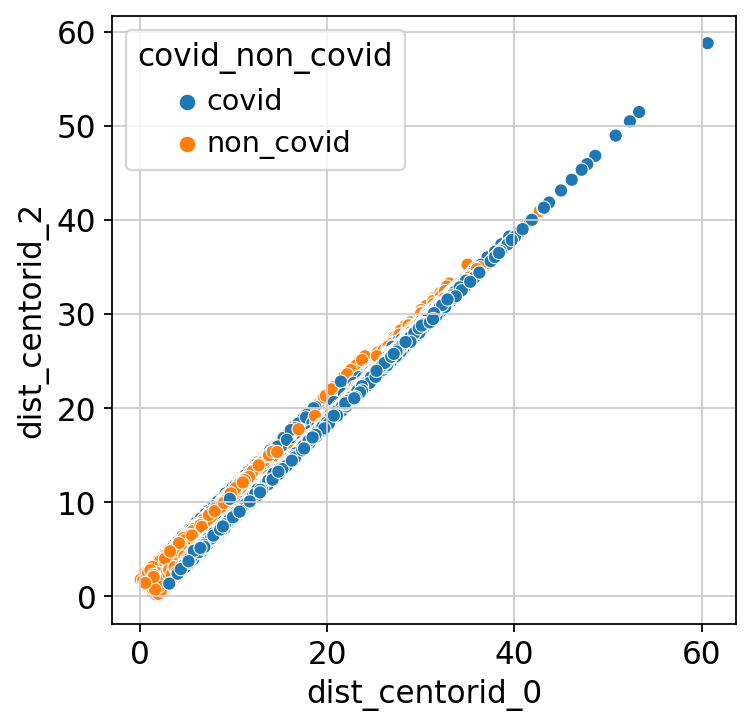

In [34]:
### Compute a distance
for i in range(len(exist_sample_centroids)):
    cur_centroid = np.array(exist_sample_centroids[i])
    # Traverse each row to calculate the distance between the centroid 
    # and the coordinates of each sample.
    temp_dist_sample_centroids = []
    for index, row in df_exist.iterrows():
        coord = np.array([row['pca1'], row['pca2']])
        dist = np.linalg.norm(cur_centroid - coord)

        temp_dist_sample_centroids.append(dist)
    
    # Add dinstances between each row and selected centroid to existing df.
    df_exist[f'dist_centorid_{i}'] = temp_dist_sample_centroids

# Plot the result of the transformation in distance between each sample and centroids
sc.set_figure_params(figsize=(5, 5))
sns.scatterplot(data=df_exist, x="dist_centorid_0", y="dist_centorid_2", hue='covid_non_covid')

In [35]:
df_exist

basis_value       sample       pca1  \
0       [3.7533211708068848, -13.429734230041504]   COVID-19_1   3.753321   
1        [3.979201555252075, -12.973167419433594]   COVID-19_1   3.979202   
2         [1.532645344734192, -9.951640129089355]   COVID-19_1   1.532645   
3         [0.575897753238678, -8.628656387329102]   COVID-19_1   0.575898   
4        [3.398256540298462, -12.020442962646484]   COVID-19_1   3.398257   
...                                           ...          ...        ...   
114696    [8.101748543398035, 13.275000602768772]  COVID-19_12   8.101749   
114697  [-11.124620946498428, 18.713409963723393]  COVID-19_12 -11.124621   
114698  [-1.3863679180231596, -5.933936059492354]  COVID-19_12  -1.386368   
114699    [-6.08839628749764, 11.881802966568767]  COVID-19_12  -6.088396   
114700   [-3.4020521565539674, -4.53180434856137]  COVID-19_12  -3.402052   

             pca2 covid_non_covid  dist_centorid_0  dist_centorid_1  \
0      -13.429734           covid         5.129404         8.589574   
1      -12.973167           covid         4.644492         8.081833   
2       -9.951640           covid         3.442353         7.039470   
3       -8.628656           covid         4.022086         7.120119   
4      -12.020443           covid         3.840912         7.462785   
...           ...             ...              ...              ...   
114696  13.275001           covid        21.927067        18.767811   
114697  18.713410           covid        31.311199        30.182020   
114698  -5.933936           covid         6.453017         8.350802   
114699  11.881803           covid        22.893510        21.694987   
114700  -4.531804           covid         8.865107        10.394186   

        dist_centorid_2  dist_centorid_3  dist_centorid_4  ...  \
0              6.671104        17.406482        14.286693  ...   
1              6.221054        17.046321        13.962573  ...   
2              3.851854        13.450437        10.234323  ...   
3              3.630159        11.954531         8.678404  ...   
4              5.269435        15.956906        12.854279  ...   
...                 ...              ...              ...  ...   
114696        20.514499        14.081621        16.881555  ...   
114697        29.465933        18.248790        21.140596  ...   
114698         5.140537         9.054547         5.643689  ...   
114699        21.048673         9.824597        12.891505  ...   
114700         7.431178         7.846608         4.471981  ...   

        dist_centorid_14  dist_centorid_15  dist_centorid_16  \
0              14.027232         18.295342         15.064783   
1              13.518951         17.786809         14.713988   
2              12.668615         16.323544         11.085383   
3              12.566291         15.866286          9.582256   
4              13.024260         17.160092         13.618339   
...                  ...               ...               ...   
114696         14.803673         10.263642         15.617721   
114697         29.656145         26.835969         20.470288   
114698         13.018040         15.446020          6.710774   
114699         21.394000         19.000802         12.109487   
114700         14.542489         16.371256          5.722687   

        dist_centorid_17  dist_centorid_18  dist_centorid_19  \
0              15.107873         16.387985         18.459283   
1              14.625975         16.079034         18.225381   
2              14.772737         12.301646         14.340396   
3              15.048452         10.713960         12.707832   
4              14.414607         14.966559         17.115335   
...                  ...               ...               ...   
114696         17.208478         16.525509         19.107031   
114697         33.353246         19.034325         17.629753   
114698         16.128202          7.536253          9.374570   
114699         25.182645         10.889611         10.3498

In [36]:
from sklearn.svm import SVC

# Prepare training data for building the model
X_train = df_exist.drop(['basis_value', 'sample', 'covid_non_covid'], axis=1)
y_train = df_exist['covid_non_covid']

# Instantiate the model
cls = SVC()
# Train/Fit the model 
cls.fit(X_train, y_train)

SVC()

In [37]:
# Get distance between a new sample and existing centroids
for i in range(len(exist_sample_centroids)):
    cur_centroid = np.array(exist_sample_centroids[i])
    # Traverse each row to calculate the distance between the centroid 
    # and the coordinates of each sample.
    temp_dist_sample_centroids = []
    for index, row in df_new.iterrows():
        coord = np.array([row['pca1'], row['pca2']])
        dist = np.linalg.norm(cur_centroid - coord)

        temp_dist_sample_centroids.append(dist)
    
    # Add dinstances between each row and selected centroid to existing df.
    df_new[f'dist_centorid_{i}'] = temp_dist_sample_centroids

# Run prediction
X_test = df_new.drop(['basis_value', 'sample', 'covid_non_covid'], axis=1)
y_test = df_new['covid_non_covid']
y_pred = cls.predict(X_test)

df_new['y_pred'] = y_pred

/tmp/ipykernel_2683198/487225352.py:14: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_new[f'dist_centorid_{i}'] = temp_dist_sample_centroids
/tmp/ipykernel_2683198/487225352.py:14: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_new[f'dist_centorid_{i}'] = temp_dist_sample_centroids
/tmp/ipykernel_2683198/487225352.py:14: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentatio

In [38]:
y_true = y_test.to_list()

In [39]:
#Import scikit-learn metrics module for accuracy calculation
from sklearn import metrics

# Model Accuracy: how often is the classifier correct?
print("Accuracy:",metrics.accuracy_score(y_true, y_pred))

# Model Precision: what percentage of positive tuples are labeled as such?
print("Precision:",metrics.precision_score(y_true, y_pred,  average='micro'))

# Model Recall: what percentage of positive tuples are labelled as such?
print("Recall:",metrics.recall_score(y_true, y_pred, average='micro'))

Accuracy: 0.36170316301703165
Precision: 0.36170316301703165
Recall: 0.36170316301703165


## Sample Classification: Scenario 3.3

### Input data
UMAP representation (UMAP 1 - UMAP 2)

### Method
Get clusters as well as a centroid of covid and non_covid in UMAP representation. Encode two sample clusters into further by Euclidian distance between those centroids. Apply some linear classifier to train. Count the label prediction of a new sample because it’s encoded into distance expression, so that it derives how many cells are close with each exciting cluster/samples (covid or non-covid). 

This implementation is the same as this paper: 
A study on using data clustering for feature extraction to improve the quality of classification


In [43]:
basis_values = adata.obsm['X_pca'][:, :2]
sample_vector = adata.obs['sample'].values
x_basis_value = []
y_basis_value = []

for b_v in basis_values:
    x_basis_value.append(b_v[0])
    y_basis_value.append(b_v[1])

df = pd.DataFrame(list(zip(basis_values, sample_vector, x_basis_value, y_basis_value)),
               columns =['basis_value', 'sample', 'pca1', 'pca2'])
df.head()

X = np.stack(df.basis_value.values.tolist()[:])
y = df['sample'].tolist()
clf = NearestCentroid()
clf.fit(X, y)

#print("Centroids:", clf.centroids_)


NearestCentroid()

In [44]:
df

basis_value       sample       pca1  \
0       [3.7533211708068848, -13.429734230041504]   COVID-19_1   3.753321   
1        [3.979201555252075, -12.973167419433594]   COVID-19_1   3.979202   
2         [1.532645344734192, -9.951640129089355]   COVID-19_1   1.532645   
3         [0.575897753238678, -8.628656387329102]   COVID-19_1   0.575898   
4        [3.398256540298462, -12.020442962646484]   COVID-19_1   3.398257   
...                                           ...          ...        ...   
114696    [8.101748543398035, 13.275000602768772]  COVID-19_12   8.101749   
114697  [-11.124620946498428, 18.713409963723393]  COVID-19_12 -11.124621   
114698  [-1.3863679180231596, -5.933936059492354]  COVID-19_12  -1.386368   
114699    [-6.08839628749764, 11.881802966568767]  COVID-19_12  -6.088396   
114700   [-3.4020521565539674, -4.53180434856137]  COVID-19_12  -3.402052   

             pca2  
0      -13.429734  
1      -12.973167  
2       -9.951640  
3       -8.628656  
4      -12.020443  
...           ...  
114696  13.275001  
114697  18.713410  
114698  -5.933936  
114699  11.881803  
114700  -4.531804  

[114701 rows x 4 columns]

In [45]:
# umap1 = adata.obsm['X_umap'][:, 0]
# umap2 = adata.obsm['X_umap'][:, 1]
# sample_vector = adata.obs['sample'].values

# df = pd.DataFrame(list(zip(umap1, umap2, sample_vector)),
#                columns =['umap1', 'umap2', 'sample'])
# df

In [46]:
list_covid_non_covid = []
for index, row in df.iterrows():
     if 'covid' in row['sample'] or 'COVID' in row['sample']:
          list_covid_non_covid.append('covid')
     else:
          list_covid_non_covid.append('non_covid')

df['covid_non_covid'] = list_covid_non_covid
df

basis_value       sample       pca1  \
0       [3.7533211708068848, -13.429734230041504]   COVID-19_1   3.753321   
1        [3.979201555252075, -12.973167419433594]   COVID-19_1   3.979202   
2         [1.532645344734192, -9.951640129089355]   COVID-19_1   1.532645   
3         [0.575897753238678, -8.628656387329102]   COVID-19_1   0.575898   
4        [3.398256540298462, -12.020442962646484]   COVID-19_1   3.398257   
...                                           ...          ...        ...   
114696    [8.101748543398035, 13.275000602768772]  COVID-19_12   8.101749   
114697  [-11.124620946498428, 18.713409963723393]  COVID-19_12 -11.124621   
114698  [-1.3863679180231596, -5.933936059492354]  COVID-19_12  -1.386368   
114699    [-6.08839628749764, 11.881802966568767]  COVID-19_12  -6.088396   
114700   [-3.4020521565539674, -4.53180434856137]  COVID-19_12  -3.402052   

             pca2 covid_non_covid  
0      -13.429734           covid  
1      -12.973167           covid  
2       -9.951640           covid  
3       -8.628656           covid  
4      -12.020443           covid  
...           ...             ...  
114696  13.275001           covid  
114697  18.713410           covid  
114698  -5.933936           covid  
114699  11.881803           covid  
114700  -4.531804           covid  

[114701 rows x 5 columns]

In [48]:
list_samples = df['sample'].unique()

y_train, y_test = train_test_split(list_samples, test_size=0.20, random_state=RANDOM_SEED)

print("Samples for getting centroids of existing samples (covid and non-covid):", y_train) # 4 samples
print("Samples for testing:", y_test) # 2 samples

Samples for getting centroids of existing samples (covid and non-covid): ['COVID-19_9' 'Control_2' 'Control_8' 'COVID-19_12' 'COVID-19_2'
 'COVID-19_8' 'Control_10' 'Control_11' 'Control_9' 'COVID-19_1'
 'Influenza_2' 'COVID-19_6' 'COVID-19_15' 'COVID-19_11' 'Control_6'
 'Control_12' 'Control_13' 'COVID-19_4' 'Control_7' 'Control_1'
 'Control_5' 'COVID-19_10' 'COVID-19_7' 'COVID-19_13']
Samples for testing: ['COVID-19_3' 'COVID-19_14' 'COVID-19_5' 'Control_3' 'Influenza_1'
 'Control_4']


In [49]:
# Get a centroid of each sample: exist (train)
y_train = list(y_train)
df_exist = df.query("sample == @y_train")
X = np.stack(df_exist.basis_value.values.tolist()[:])
y = df_exist['sample'].tolist()
clf = NearestCentroid()
clf.fit(X, y)

y_test = list(y_test)
df_new = df.query("sample == @y_test")
#df_new

X_new = np.stack(df_new.basis_value.values.tolist()[:])
y_new = df_new['sample'].tolist()

y_pred = []
for x_new in X_new:
    y_pred.append(clf.predict([x_new]))

y_pred = np.squeeze(np.stack(y_pred[:]))

# Get a centroid of each sample: new (test)
X_new = np.stack(df_new.basis_value.values.tolist()[:])
y_new = df_new['sample'].tolist()

clf_new = NearestCentroid()
clf_new.fit(X_new, y_new)

exist_sample_centroids = clf.centroids_
new_sample_centroids = clf_new.centroids_

# result_dict = dict(zip(np.unique(np.array(y_new)),clf_new.centroids_))
# print(result_dict)

# Make covid_non_covid column
list_covid_non_covid = []
for index, row in df_exist.iterrows():
     if 'covid' in row['sample'] or 'COVID' in row['sample']:
          list_covid_non_covid.append('covid')
     else:
          list_covid_non_covid.append('non_covid')

df_exist['covid_non_covid'] = list_covid_non_covid

list_covid_non_covid = []
for index, row in df_new.iterrows():
     if 'covid' in row['sample'] or 'COVID' in row['sample']:
          list_covid_non_covid.append('covid')
     else:
          list_covid_non_covid.append('non_covid')

df_new['covid_non_covid'] = list_covid_non_covid

/tmp/ipykernel_2683198/2981173161.py:43: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_exist['covid_non_covid'] = list_covid_non_covid
/tmp/ipykernel_2683198/2981173161.py:52: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_new['covid_non_covid'] = list_covid_non_covid


/tmp/ipykernel_2683198/447276703.py:14: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_exist[f'dist_centorid_{i}'] = temp_dist_sample_centroids
/tmp/ipykernel_2683198/447276703.py:14: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_exist[f'dist_centorid_{i}'] = temp_dist_sample_centroids
/tmp/ipykernel_2683198/447276703.py:14: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the document

<AxesSubplot:xlabel='dist_centorid_0', ylabel='dist_centorid_2'>

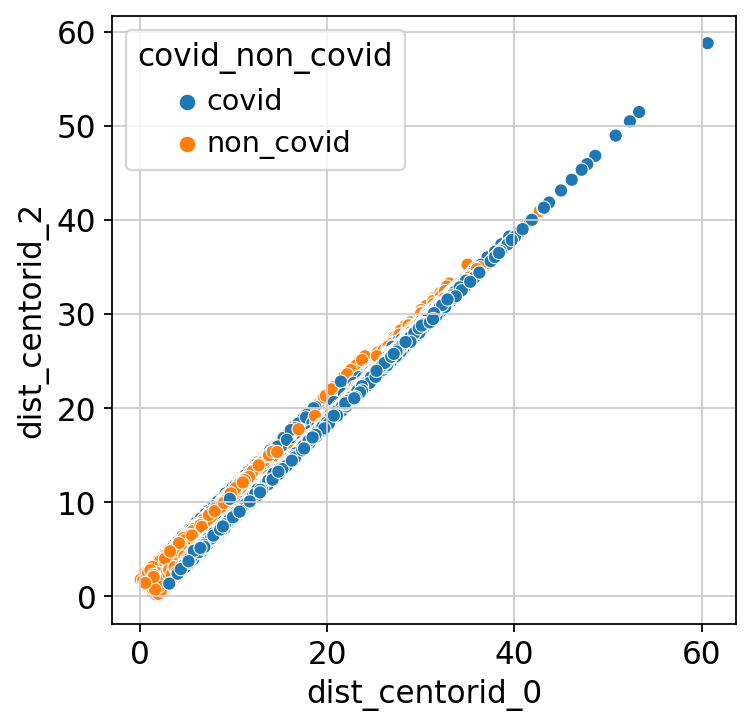

In [50]:
### Compute a distance
for i in range(len(exist_sample_centroids)):
    cur_centroid = np.array(exist_sample_centroids[i])
    # Traverse each row to calculate the distance between the centroid 
    # and the coordinates of each sample.
    temp_dist_sample_centroids = []
    for index, row in df_exist.iterrows():
        coord = np.array([row['pca1'], row['pca2']])
        dist = np.linalg.norm(cur_centroid - coord)

        temp_dist_sample_centroids.append(dist)
    
    # Add dinstances between each row and selected centroid to existing df.
    df_exist[f'dist_centorid_{i}'] = temp_dist_sample_centroids

# Plot the result of the transformation in distance between each sample and centroids
sc.set_figure_params(figsize=(5, 5))
sns.scatterplot(data=df_exist, x="dist_centorid_0", y="dist_centorid_2", hue='covid_non_covid')

In [51]:
df_exist

basis_value       sample       pca1  \
0       [3.7533211708068848, -13.429734230041504]   COVID-19_1   3.753321   
1        [3.979201555252075, -12.973167419433594]   COVID-19_1   3.979202   
2         [1.532645344734192, -9.951640129089355]   COVID-19_1   1.532645   
3         [0.575897753238678, -8.628656387329102]   COVID-19_1   0.575898   
4        [3.398256540298462, -12.020442962646484]   COVID-19_1   3.398257   
...                                           ...          ...        ...   
114696    [8.101748543398035, 13.275000602768772]  COVID-19_12   8.101749   
114697  [-11.124620946498428, 18.713409963723393]  COVID-19_12 -11.124621   
114698  [-1.3863679180231596, -5.933936059492354]  COVID-19_12  -1.386368   
114699    [-6.08839628749764, 11.881802966568767]  COVID-19_12  -6.088396   
114700   [-3.4020521565539674, -4.53180434856137]  COVID-19_12  -3.402052   

             pca2 covid_non_covid  dist_centorid_0  dist_centorid_1  \
0      -13.429734           covid         5.129404         8.589574   
1      -12.973167           covid         4.644492         8.081833   
2       -9.951640           covid         3.442353         7.039470   
3       -8.628656           covid         4.022086         7.120119   
4      -12.020443           covid         3.840912         7.462785   
...           ...             ...              ...              ...   
114696  13.275001           covid        21.927067        18.767811   
114697  18.713410           covid        31.311199        30.182020   
114698  -5.933936           covid         6.453017         8.350802   
114699  11.881803           covid        22.893510        21.694987   
114700  -4.531804           covid         8.865107        10.394186   

        dist_centorid_2  dist_centorid_3  dist_centorid_4  ...  \
0              6.671104        17.406482        14.286693  ...   
1              6.221054        17.046321        13.962573  ...   
2              3.851854        13.450437        10.234323  ...   
3              3.630159        11.954531         8.678404  ...   
4              5.269435        15.956906        12.854279  ...   
...                 ...              ...              ...  ...   
114696        20.514499        14.081621        16.881555  ...   
114697        29.465933        18.248790        21.140596  ...   
114698         5.140537         9.054547         5.643689  ...   
114699        21.048673         9.824597        12.891505  ...   
114700         7.431178         7.846608         4.471981  ...   

        dist_centorid_14  dist_centorid_15  dist_centorid_16  \
0              14.027232         18.295342         15.064783   
1              13.518951         17.786809         14.713988   
2              12.668615         16.323544         11.085383   
3              12.566291         15.866286          9.582256   
4              13.024260         17.160092         13.618339   
...                  ...               ...               ...   
114696         14.803673         10.263642         15.617721   
114697         29.656145         26.835969         20.470288   
114698         13.018040         15.446020          6.710774   
114699         21.394000         19.000802         12.109487   
114700         14.542489         16.371256          5.722687   

        dist_centorid_17  dist_centorid_18  dist_centorid_19  \
0              15.107873         16.387985         18.459283   
1              14.625975         16.079034         18.225381   
2              14.772737         12.301646         14.340396   
3              15.048452         10.713960         12.707832   
4              14.414607         14.966559         17.115335   
...                  ...               ...               ...   
114696         17.208478         16.525509         19.107031   
114697         33.353246         19.034325         17.629753   
114698         16.128202          7.536253          9.374570   
114699         25.182645         10.889611         10.3498

In [52]:
from sklearn.svm import SVC

# Prepare training data for building the model
# Use only the new features: distance value between the cell and the sample's centroid.
X_train = df_exist.drop(['basis_value', 'sample', 'pca1', 'pca2','covid_non_covid'], axis=1)
y_train = df_exist['covid_non_covid']

# Instantiate the model
cls = SVC()
# Train/Fit the model 
cls.fit(X_train, y_train)

SVC()

In [53]:
# Get distance between a new sample and existing centroids
for i in range(len(exist_sample_centroids)):
    cur_centroid = np.array(exist_sample_centroids[i])
    # Traverse each row to calculate the distance between the centroid 
    # and the coordinates of each sample.
    temp_dist_sample_centroids = []
    for index, row in df_new.iterrows():
        coord = np.array([row['pca1'], row['pca2']])
        dist = np.linalg.norm(cur_centroid - coord)

        temp_dist_sample_centroids.append(dist)
    
    # Add dinstances between each row and selected centroid to existing df.
    df_new[f'dist_centorid_{i}'] = temp_dist_sample_centroids

# Run prediction
X_test = df_new.drop(['basis_value', 'sample', 'pca1', 'pca2', 'covid_non_covid'], axis=1)
y_test = df_new['covid_non_covid']
y_pred = cls.predict(X_test)

df_new['y_pred'] = y_pred

/tmp/ipykernel_2683198/3717975488.py:14: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_new[f'dist_centorid_{i}'] = temp_dist_sample_centroids
/tmp/ipykernel_2683198/3717975488.py:14: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_new[f'dist_centorid_{i}'] = temp_dist_sample_centroids
/tmp/ipykernel_2683198/3717975488.py:14: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documenta

In [54]:
y_true = y_test.to_list()

#Import scikit-learn metrics module for accuracy calculation
from sklearn import metrics

# Model Accuracy: how often is the classifier correct?
print("Accuracy:",metrics.accuracy_score(y_true, y_pred))

# Model Precision: what percentage of positive tuples are labeled as such?
print("Precision:",metrics.precision_score(y_true, y_pred,  average='micro'))

# Model Recall: what percentage of positive tuples are labelled as such?
print("Recall:",metrics.recall_score(y_true, y_pred, average='micro'))

Accuracy: 0.35897810218978105
Precision: 0.35897810218978105
Recall: 0.35897810218978105
